# Import Lib

In [2]:
import pandas as pd
import numpy as np
import cv2

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential

# useful for getting number of output classes
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image

# Splitting folder into test and train

### Run once 

In [1]:
from google.colab import drive
drive.mount("./drive")

Mounted at ./drive


In [ ]:
import splitfolders

# Split with any ratio in train, val, test set
# we do not split it in validation set since the dataset is quite small and we are not doing any hyperparameter tuning
splitfolders.ratio("./drive/MyDrive/UGP-Diabetic Retinopathy/Dataset/colored_images", output="./drive/MyDrive/UGP-Diabetic Retinopathy/Dataset/colored_images_mod",
    seed=1337, ratio=(0.8, 0, 0.2), group_prefix=None, move=False) 

# Dataset

In [3]:
train_path = './colored_images_mod/train'
test_path = './colored_images_mod/test'

In [4]:
folders = glob('./colored_images_mod/train/*')

In [5]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range = 15,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [6]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

Found 2929 images belonging to 5 classes.


In [7]:
test_set = test_datagen.flow_from_directory(test_path,
                                           target_size = (224, 224),
                                           batch_size = 64,
                                           class_mode = 'categorical')

Found 733 images belonging to 5 classes.


# VGG19

In [8]:
IMAGE_SHAPE = [224,224]

# we need to keep the weights same as the original model and just drop first and last layer
# Here we will be using imagenet weights
vgg = VGG19(input_shape=IMAGE_SHAPE + [3], weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 8s 0us/step


In [9]:
# don't train existing weights 
for layer in vgg.layers:
    layer.trainable = False

In [10]:
# changing the last layers since we need 5 classes rather than 1000 which it already does
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [16]:
import scipy

In [17]:
# fit the model
# Run the cell
# It will take some time to execute, better to run on the gpu
# in our case we run it on gtx 1650ti
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
)

C:\Users\Devansh\AppData\Local\Temp\ipykernel_20348\1157158691.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


NameError: name 'scipy' is not defined

# Plot

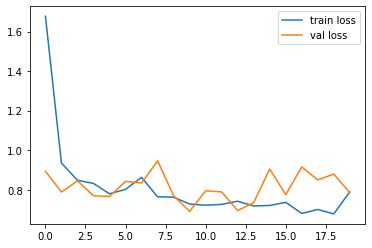

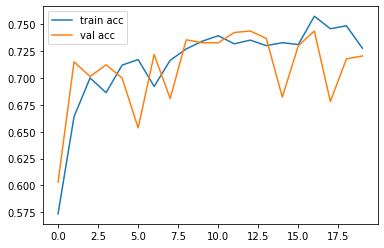

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

# Prediction

In [ ]:
folders

['archive/colored_images_mod/train\\Mild',
 'archive/colored_images_mod/train\\Moderate',
 'archive/colored_images_mod/train\\No_DR',
 'archive/colored_images_mod/train\\Proliferate_DR',
 'archive/colored_images_mod/train\\Severe']

In [ ]:
# prediction for the test_set where integers correlate to the classes
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

y_pred

array([0, 2, 2, 2, 2, 0, 0, 2, 1, 2, 4, 0, 0, 2, 0, 2, 2, 2, 1, 2, 1, 0,
       2, 0, 2, 1, 1, 2, 2, 2, 1, 2, 0, 1, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 2, 1, 0, 1, 2, 2, 0, 2, 0,
       0, 1, 0, 1, 2, 2, 1, 1, 2, 0, 2, 2, 2, 0, 0, 0, 1, 0, 2, 2, 1, 2,
       1, 2, 2, 2, 2, 1, 2, 1, 0, 2, 2, 1, 0, 2, 4, 0, 2, 1, 1, 1, 0, 2,
       2, 2, 2, 1, 2, 1, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 1, 2, 2, 0,
       0, 1, 2, 1, 0, 1, 2, 0, 1, 2, 0, 0, 2, 2, 1, 2, 1, 0, 0, 0, 2, 2,
       2, 0, 0, 3, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 1, 2, 2, 1,
       2, 2, 1, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 1, 0, 1, 1,
       2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2,
       2, 0, 0, 2, 0, 1, 1, 2, 2, 0, 0, 0, 2, 0, 1, 0, 2, 1, 2, 0, 0, 2,
       2, 0, 1, 2, 0, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 0, 2,
       2, 2, 2, 2, 4, 1, 0, 2, 2, 2, 2, 0, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 1, 0, 2, 0, 1, 2, 1, 0, 1, 2, 4, 2, 2,